In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Ford.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_B-Max,Seri_C-Max,Seri_Escort,...,Model_2.0 XR,Model_2.3 RS,Model_2.5 Ghia,Model_4.6 GT,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,460000,2012,96,1388,90000,9.0,3.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,480000,2014,95,1560,205000,0.0,4.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,899000,2018,160,1498,185000,3.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,399000,2011,70,1398,168000,4.0,2.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,85000,1992,101,1592,300000,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_17780\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,67950.173249,4.887958e+09,69913.933543,37860.862702


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:11:32,752] A new study created in memory with name: no-name-6f07e1ea-73c0-4002-80ff-6b7f47651b65
[I 2023-10-08 14:11:33,081] Trial 1 finished with value: 130980.56976135651 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.3464372144475824, 'max_depth': 3, 'min_child_weight': 214}. Best is trial 1 with value: 130980.56976135651.
[I 2023-10-08 14:11:33,091] Trial 0 finished with value: 328998.2103337118 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.04997893233511039, 'max_depth': 4, 'min_child_weight': 247}. Best is trial 1 with value: 130980.56976135651.
[I 2023-10-08 14:11:33,091] Trial 6 finished with value: 498146.3265690067 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.0015364918710682955, 'max_depth': 4, 'min_child_weight': 186}. Best is trial 1 with value: 130980.56976135651.
[I 2023-10-08 14:11:33,126] Trial 3 finished with value: 331854.9507734082 and parameters: {'co

[I 2023-10-08 14:11:34,832] Trial 30 finished with value: 145411.26042028132 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.1557821616120847, 'max_depth': 13, 'min_child_weight': 41}. Best is trial 21 with value: 85113.26330566415.
[I 2023-10-08 14:11:34,863] Trial 32 finished with value: 149131.88199511942 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.1549804744515868, 'max_depth': 13, 'min_child_weight': 36}. Best is trial 21 with value: 85113.26330566415.
[I 2023-10-08 14:11:34,863] Trial 29 finished with value: 163495.71053377265 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.13555441598684792, 'max_depth': 13, 'min_child_weight': 33}. Best is trial 21 with value: 85113.26330566415.
[I 2023-10-08 14:11:34,910] Trial 35 finished with value: 143094.5442822891 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.15857577758115496, 'max_depth': 13, 'min_child_weigh

[I 2023-10-08 14:11:37,118] Trial 59 finished with value: 215074.44055166858 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.0956995483769352, 'max_depth': 11, 'min_child_weight': 1}. Best is trial 21 with value: 85113.26330566415.
[I 2023-10-08 14:11:37,118] Trial 62 finished with value: 225605.21749437763 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.09024407631555002, 'max_depth': 11, 'min_child_weight': 4}. Best is trial 21 with value: 85113.26330566415.
[I 2023-10-08 14:11:37,175] Trial 61 finished with value: 88116.67648191171 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3177484765979261, 'max_depth': 11, 'min_child_weight': 5}. Best is trial 21 with value: 85113.26330566415.
[I 2023-10-08 14:11:37,307] Trial 63 finished with value: 77398.68334722509 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3404525130559429, 'max_depth': 11, 'min_child_weight': 2

[I 2023-10-08 14:11:39,588] Trial 90 finished with value: 106152.78047096069 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.41010697820142344, 'max_depth': 12, 'min_child_weight': 190}. Best is trial 63 with value: 77398.68334722509.
[I 2023-10-08 14:11:39,649] Trial 91 finished with value: 142323.30160579103 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.298245963653484, 'max_depth': 7, 'min_child_weight': 274}. Best is trial 63 with value: 77398.68334722509.
[I 2023-10-08 14:11:39,681] Trial 92 finished with value: 136462.76717569958 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.40573410882702476, 'max_depth': 12, 'min_child_weight': 270}. Best is trial 63 with value: 77398.68334722509.
[I 2023-10-08 14:11:39,743] Trial 93 finished with value: 199920.1366248095 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.11750106955881509, 'max_depth': 7, 'min_child_weig

[I 2023-10-08 14:11:42,005] Trial 121 finished with value: 100302.8244592792 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.4155192321503977, 'max_depth': 13, 'min_child_weight': 84}. Best is trial 63 with value: 77398.68334722509.
[I 2023-10-08 14:11:42,021] Trial 120 finished with value: 95497.86988156382 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.40233350906841725, 'max_depth': 13, 'min_child_weight': 24}. Best is trial 63 with value: 77398.68334722509.
[I 2023-10-08 14:11:42,083] Trial 122 finished with value: 98027.57607997234 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.32485701719802457, 'max_depth': 13, 'min_child_weight': 20}. Best is trial 63 with value: 77398.68334722509.
[I 2023-10-08 14:11:42,130] Trial 123 finished with value: 92695.84387743995 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.3072180096855677, 'max_depth': 13, 'min_child_weig

[I 2023-10-08 14:11:44,624] Trial 150 finished with value: 95423.29987014094 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.2934550066315179, 'max_depth': 11, 'min_child_weight': 16}. Best is trial 63 with value: 77398.68334722509.
[I 2023-10-08 14:11:44,968] Trial 153 finished with value: 97251.11761183418 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.2793259121190282, 'max_depth': 12, 'min_child_weight': 9}. Best is trial 63 with value: 77398.68334722509.
[I 2023-10-08 14:11:45,016] Trial 152 finished with value: 85776.734008427 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.49535049765657546, 'max_depth': 12, 'min_child_weight': 9}. Best is trial 63 with value: 77398.68334722509.
[I 2023-10-08 14:11:45,024] Trial 151 finished with value: 95673.56000163518 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.30404078848920624, 'max_depth': 12, 'min_child_weight':

[I 2023-10-08 14:11:47,882] Trial 180 finished with value: 80493.49915257782 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.41269260705953026, 'max_depth': 14, 'min_child_weight': 1}. Best is trial 63 with value: 77398.68334722509.
[I 2023-10-08 14:11:48,050] Trial 181 finished with value: 423031.569328055 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.019246567846018938, 'max_depth': 14, 'min_child_weight': 1}. Best is trial 63 with value: 77398.68334722509.
[I 2023-10-08 14:11:48,050] Trial 182 finished with value: 482846.5415863593 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.004923463098922719, 'max_depth': 14, 'min_child_weight': 100}. Best is trial 63 with value: 77398.68334722509.
[I 2023-10-08 14:11:48,215] Trial 183 finished with value: 369832.5407996961 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.0353089751471449, 'max_depth': 14, 'min_child_wei

[I 2023-10-08 14:11:51,216] Trial 211 finished with value: 91001.87919731399 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.319764857526912, 'max_depth': 14, 'min_child_weight': 7}. Best is trial 63 with value: 77398.68334722509.
[I 2023-10-08 14:11:51,282] Trial 213 finished with value: 116046.52316970124 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3294780101303672, 'max_depth': 14, 'min_child_weight': 171}. Best is trial 63 with value: 77398.68334722509.
[I 2023-10-08 14:11:51,313] Trial 210 finished with value: 90584.4589113898 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.32243085100075036, 'max_depth': 14, 'min_child_weight': 7}. Best is trial 63 with value: 77398.68334722509.
[I 2023-10-08 14:11:51,313] Trial 212 finished with value: 94411.52599777846 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.32496896571074185, 'max_depth': 14, 'min_child_weight

[I 2023-10-08 14:11:54,273] Trial 241 finished with value: 81415.05048761348 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.37785733576085134, 'max_depth': 15, 'min_child_weight': 2}. Best is trial 229 with value: 76543.67619817932.
[I 2023-10-08 14:11:54,289] Trial 243 finished with value: 80350.95369780897 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.3771252214562738, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 229 with value: 76543.67619817932.
[I 2023-10-08 14:11:54,289] Trial 239 finished with value: 82460.86770406686 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.39827373818002143, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 229 with value: 76543.67619817932.
[I 2023-10-08 14:11:54,289] Trial 238 finished with value: 82305.19600064907 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.396597326525805, 'max_depth': 15, 'min_child_weigh

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 76543.6762
Best params:
	colsample_bytree: 0.9
	subsample: 0.8
	learning_rate: 0.3750129557614683
	max_depth: 15
	min_child_weight: 2


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 69908.3178630304, 'MSE': 5360131627.789299, 'RMSE': 73212.91981467, 'MAE': 42069.45138650412}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.8868182027111854

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8767931141194932

In [16]:
marka_model = joblib.dump(final_model, "Ford.pkl")

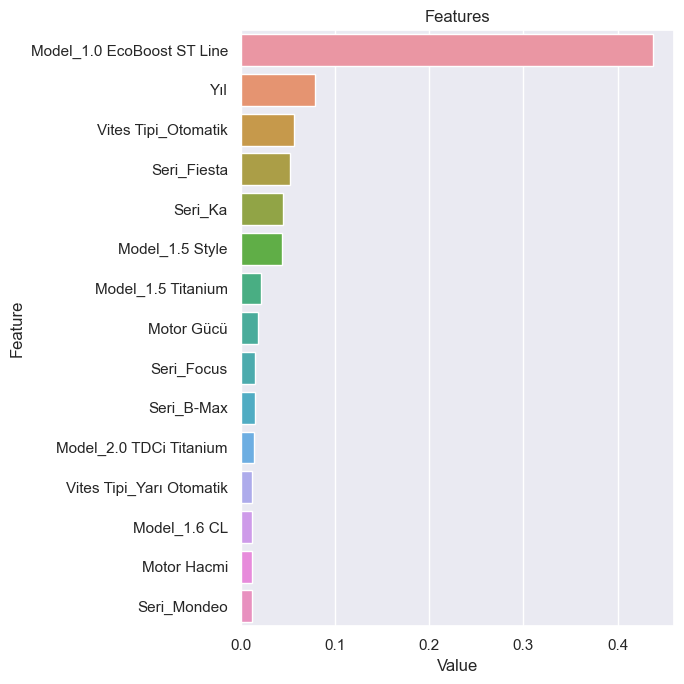

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)